In [1]:
import pymc as pm
import pytensor.tensor as tt
from pytensor.tensor.slinalg import cholesky
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from Bio import Phylo

In [2]:
# Load behavior data
behavior_file = "LogBehaviorData.txt"
behavior_dataframe = pd.read_csv(behavior_file, delimiter='\t')

In [3]:
behavior_dataframe[:3]

,id,animal,1,2,3,4,5,6,7,8,...,125,126,127,128,129,130,131,132,133,134
0,1,yakuba,-12.2246,-8.9665,-9.0465,-12.2246,-6.8041,-10.0274,-10.4328,-7.2973,...,-7.9071,-7.5151,-5.7569,-5.4233,-9.5855,-5.6650,-4.8462,-3.5795,-4.8812,-12.2246
1,2,melanogaster,-12.0475,-5.9382,-7.4936,-9.6496,-7.2191,-8.1763,-12.0475,-7.6780,...,-6.3673,-5.1899,-7.3290,-4.9827,-6.9058,-3.9577,-4.6530,-5.0928,-5.4738,-7.1058
2,3,melanogaster,-11.9779,-8.7590,-9.4130,-11.9779,-9.4130,-9.2699,-11.9779,-10.1862,...,-6.0726,-5.2772,-4.8771,-4.7701,-7.1821,-4.5964,-4.0179,-4.1439,-5.3686,-9.1447


### Parse Tree

In [4]:
# --- Parse phylogenetic tree ---
newick = "((yakuba:0.09,santomea:0.09)oldyasa:0.44,((sechelia:0.15,simulans:0.15,mauritiana:0.15)oldsim:0.14,melanogaster:0.29)oldmela:0.24);"
tree = Phylo.read(StringIO(newick), "newick")

In [5]:
# First, calculate the current tree height (max root-to-tip distance)
def get_max_distance(tree):
    return max(tree.depths().values())

original_height = get_max_distance(tree)

# Scale all branch lengths so that the height becomes 1
scaling_factor = 1.0 / original_height

for clade in tree.find_clades():
    if clade.branch_length:
        clade.branch_length *= scaling_factor

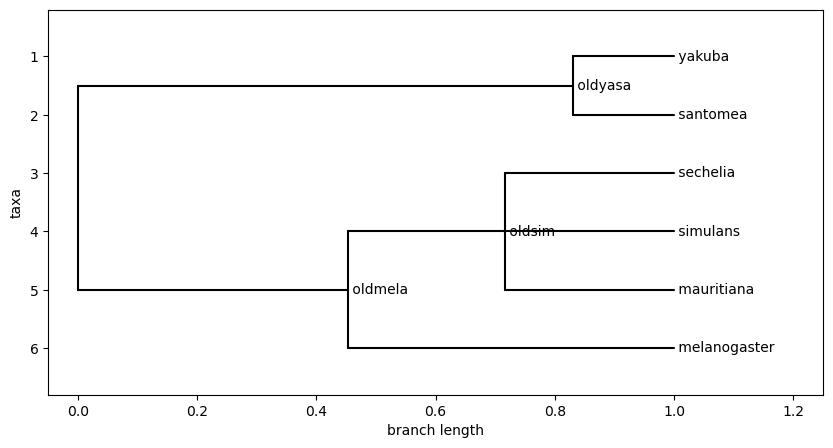

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
Phylo.draw(tree, axes=ax, do_show=False)
plt.show()

### Look at similarity as a function of phylogenetic distance

In [7]:
from scipy.spatial.distance import pdist, squareform

In [8]:
# individuals
feat = [str(i) for i in range(1, 135)]
# recover per‐indiv distributions & aggregate per species
probs = np.exp(behavior_dataframe[feat].values)
probs /= probs.sum(1, keepdims=True)
distance_behavior = squareform(pdist(probs, metric='jensenshannon'))
# individual similarity

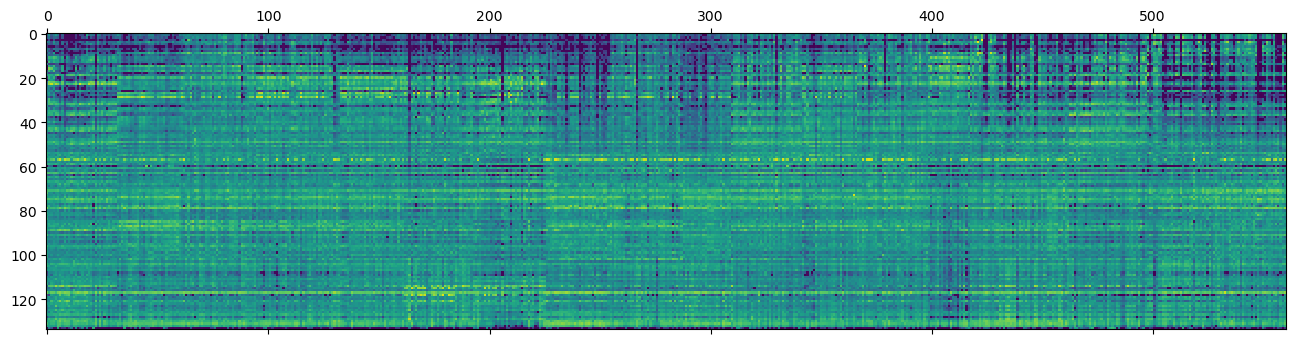

In [9]:
plt.matshow(behavior_dataframe[feat].values.T)

In [10]:
unique_species = ['yakuba', 'santomea', 'sechelia', 'simulans', 'mauritiana', 'melanogaster']#behavior_dataframe['animal'].unique()

In [11]:
# recover per‐indiv distributions & aggregate per species
probs = np.exp(behavior_dataframe[feat].values)
probs /= probs.sum(1, keepdims=True)
species_probs = [probs[ behavior_dataframe['animal'] == species].mean(axis=0) for species in unique_species]

In [12]:
distances_behavior_species = squareform(pdist(species_probs, metric='jensenshannon'))

In [13]:
distance_phylo_species = np.zeros((len(unique_species), len(unique_species)))
for si, species_i in enumerate(unique_species):
    for sj, species_j in enumerate(unique_species):
        distance_phylo_species[si, sj] = tree.distance(species_i, species_j)

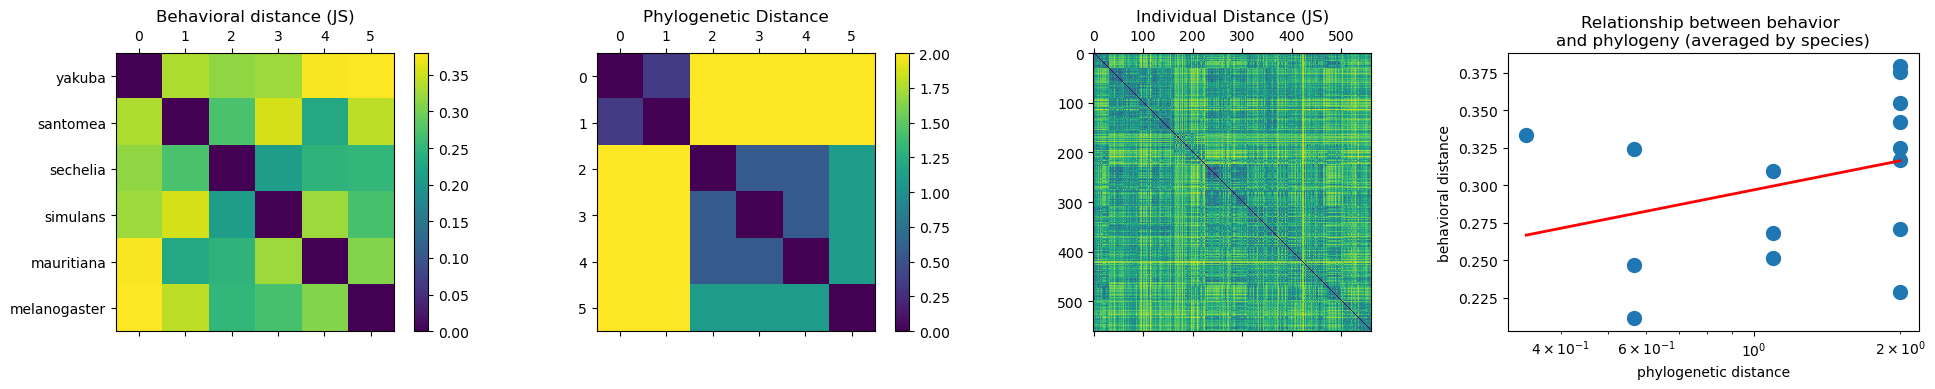

In [14]:
fig, axs = plt.subplots(ncols=4, figsize=(20,4))

# 1) Behavioral distance
ax = axs[0]
ax.set_title('Behavioral distance (JS)')
cax = ax.matshow(distances_behavior_species)
ax.set_yticks(np.arange(len(unique_species)))
ax.set_yticklabels(unique_species)
plt.colorbar(cax, ax=ax)

# 2) Phylogenetic Distance
ax = axs[1]
ax.set_title('Phylogenetic Distance')
cax = ax.matshow(distance_phylo_species)
plt.colorbar(cax, ax=ax)

# 3) Individual Distance (JS)
ax = axs[2]
ax.set_title('Individual Distance (JS)')
ax.matshow(distance_behavior)

# 4) Scatter + regression
ax = axs[3]
ax.set_title('Relationship between behavior \nand phylogeny (averaged by species)')

# extract lower‐triangle pairs
m = np.tril_indices(len(unique_species), -1)
x = distance_phylo_species[m]
y = distances_behavior_species[m]

# scatter
ax.scatter(x, y, s=100)
ax.set_xscale('log')
ax.set_xlabel('phylogenetic distance')
ax.set_ylabel('behavioral distance')

# fit a linear regression on log(x) vs y
log_x = np.log(x)
slope, intercept = np.polyfit(log_x, y, 1)

# make a smooth line over the x‐range
x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = slope * np.log(x_fit) + intercept

# plot regression line
ax.plot(x_fit, y_fit, color='red', linewidth=2,
        label=f'y = {slope:.2f}·log(x) + {intercept:.2f}')
#ax.legend()

plt.tight_layout()
plt.show()

In [15]:
from scipy.stats import pearsonr
m = np.tril_indices(len(unique_species), -1)
pearsonr(
    distances_behavior_species[m],
    distance_phylo_species[m]
)

PearsonRResult(statistic=np.float64(0.3986682582846273), pvalue=np.float64(0.14104069398222202))

### Create Brownian matrix

In [16]:
from Bio.Phylo.BaseTree import Clade

def collect_all_nodes(tree):
    """
    Return a list of *all* nodes in the tree, each node having a .name
    (set for tips and internal nodes).
    """
    # Ensure each node has a unique .name, e.g. for internal nodes, we might do something like:
    # "oldmela", "oldsim", etc. If the tree lacks node names, you can auto-assign them.
    all_nodes = []
    def visit(clade):
        all_nodes.append(clade)
        for child in clade.clades:
            visit(child)
    visit(tree.root)
    return all_nodes

all_nodes = collect_all_nodes(tree)  # includes tips + internals
# Optionally filter out the root if you want a separate parameter for the root,
# but let's keep it for a full approach.
tips = all_nodes[1:]
m = len(tips)

# get distance from root to each tip
depths = tree.depths()
total_height = max(depths.values())
# shared branch length = (total_height - pairwise distance) / 2  * 2? 
# Actually for Brownian: cov(i,j) = total_height - distance(i,j)
D = np.zeros((m, m))
for i, ti in enumerate(tips):
    for j, tj in enumerate(tips):
        dij = tree.distance(ti, tj)
        D[i,j] = total_height - dij/2  # half the path from each to MRCA
# Normalize to correlation
A = D / np.diag(D)[:,None]
# Cholesky of A
chol_A = np.linalg.cholesky(A)

In [17]:
node_to_idx = {clade.name: idx for idx, clade in enumerate(tips)}
species_idx = behavior_dataframe['animal'].map(node_to_idx).values

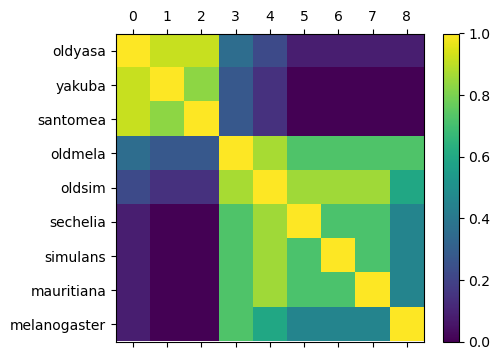

In [18]:
fig, ax = plt.subplots(ncols=1, figsize=(5,4))
cax = ax.matshow(D)
ax.set_yticks(np.arange(len(tips)))
ax.set_yticklabels(tips)
plt.colorbar(cax)


### Train model

In [19]:
Y = behavior_dataframe[feat].values
n_obs, K = Y.shape

In [ ]:
with pm.Model() as fullrank_glmm:
    
    # 2) Common‐ancestor mean
    mu = pm.Normal("mu", 0.0, 1.0, shape=K)

    # 3) Full‐rank prior for V_a
    L_va, _, _ = pm.LKJCholeskyCov(
        "L_va",
        n=K,
        eta=1.0,
        sd_dist=pm.HalfCauchy.dist(2.5),
        compute_corr=True,
    )
    V_a = pm.Deterministic("V_a", L_va @ L_va.T + 1e-6 * tt.eye(K))
    
    # 4) Phylogenetic random effects 
    z_nodes = pm.Normal("z_nodes", mu = 0.0, sigma = 1.0, shape=(m, K))
    phylo = pm.math.dot(chol_A, z_nodes) # species–species corr
    rho = pm.Deterministic("rho", pm.math.dot(phylo, L_va.T)) # trait–trait cov

    # 5) Residual covariance V(e)
    L_ve, _, _ = pm.LKJCholeskyCov(
        "L_ve",
        n=K,
        eta=1.0,
        sd_dist=pm.HalfCauchy.dist(2.5),
        compute_corr=True
    )
    V_e = pm.Deterministic("V_e", L_ve @ L_ve.T + 1e-6 * tt.eye(K))

    # 6) Likelihood
    mu_phy = rho[species_idx] + mu
    obs = pm.MvNormal(
        "obs",
        mu=mu_phy,
        chol=L_ve,
        shape=(n_obs, K),
        observed=Y,
    )

    # 7) Sample
    trace = pm.sample(
        draws=2000, # increase 
        tune=500, # increase
        target_accept=0.9, # increase
        chains=1,
        cores=1,
    )

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, L_va, z_nodes, L_ve]


Output()

/home/peromoseq/anaconda3/envs/bambi/lib/python3.12/site-packages/pytensor/tensor/subtensor.py:2585: 
RuntimeWarning: invalid value encountered in add
  np.add.at(x, idx, y)

### Analyze results

In [ ]:
V_a = np.mean(trace.posterior["V_a"].values, axis=(0,1))          # shape (chains, draws, K)
V_e = np.mean(trace.posterior["V_e"].values, axis=(0,1))         # shape (chains, draws, K)

In [ ]:
fig, axs = plt.subplots(figsize=(4,2), ncols=2)
axs[0].matshow(V_a)
axs[1].matshow(V_e)

In [ ]:
ppc = pm.sample_posterior_predictive(
    trace,
    model=fullrank_glmm
)

In [ ]:
# 3. Compute & attach the log_likelihood for your observed RV “obs”
trace = pm.compute_log_likelihood(
    trace,
    var_names=["obs"],   # or omit to grab *all* observed variables
    model=fullrank_glmm,          # the model object in whose context `obs` lives
    extend_inferencedata=True
)

In [ ]:
Y_obs = Y  # Your original dataset (NxB matrix)
Y_pred = np.mean(ppc.posterior_predictive["obs"], axis=(0, 1))  # Taking mean over draws & chains

In [ ]:
# Step 3: Compute R²
var_obs = np.var(Y_obs, axis=0)  # Variance of observed data
var_residuals = np.var(Y_obs - Y_pred, axis=0)  # Variance of residuals

r2_values = 1 - (var_residuals / var_obs)  # Compute R² per behavior
r2_mean = np.mean(r2_values)  # Average R² across behaviors

print(f"Mean R²: {np.array(r2_mean)}")

In [ ]:
fig, axs= plt.subplots(nrows=3, figsize=(20,6))
cmap = 'viridis'
axs[0].matshow(Y_obs.T, cmap=cmap)
axs[0].set_title('True Behavior Log Prob')
axs[1].matshow(Y_pred.T, cmap=cmap)
axs[1].set_title('Predicted Behavior Log Prob')
axs[2].matshow(Y_obs.T - Y_pred.T, cmap='coolwarm')
axs[2].set_title('Residual')
plt.tight_layout()

### Cluster covariance matrix Va

In [ ]:
V_a = np.mean(trace.posterior["V_a"].values, axis=(0,1))          # shape (chains, draws, K)

In [ ]:
m = len(tips)

In [ ]:
import copy
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering

In [ ]:
# Assume V_a is a covariance matrix
# Convert it to a correlation matrix first
D = np.corrcoef(V_a)

# Compute a distance matrix: 1 - correlation
distance_matrix = 1 - D

# Convert to condensed form for linkage
condensed = squareform(distance_matrix, checks=False)

# Perform hierarchical clustering
Z = linkage(condensed, method='average')

# Apply optimal leaf ordering
Z_opt = optimal_leaf_ordering(Z, condensed)

# Get reordered indices
ordered_indices = leaves_list(Z_opt)

In [ ]:
# compute covariance across species (without respect to phylogeny)
species_means = np.vstack([Y[species_idx == s].mean(axis=0)
               for s in range(m)]).T
covariance_across_species  = np.cov(
    species_means[:,np.any(np.isnan(species_means), axis=0) == False]
)

In [ ]:
fig, axs = plt.subplots(figsize=(18, 9), ncols=2)
ax = axs[0]
ax.matshow(
    V_a[np.ix_(ordered_indices, ordered_indices)],
    cmap="coolwarm",
    vmax=V_a[np.ix_(ordered_indices, ordered_indices)][np.tril_indices(len(V_a), -1)].max(),
    vmin=-V_a[np.ix_(ordered_indices, ordered_indices)][np.tril_indices(len(V_a), -1)].max(),
)
ax.set_yticks(np.arange(len(V_a)))
ax.set_yticklabels(np.arange(len(V_a))[ordered_indices])
ax.set_title("Model Covariance")

ax = axs[1]
ax.matshow(
    covariance_across_species[np.ix_(ordered_indices, ordered_indices)], cmap="viridis"
)
ax.set_yticks(np.arange(len(V_a)))
ax.set_yticklabels(np.arange(len(V_a))[ordered_indices])
ax.set_title("Covariance Across Species")

In [ ]:
pearsonr(
    V_a[np.ix_(ordered_indices, ordered_indices)][np.tril_indices(len(V_a), -1)],
    covariance_across_species[np.ix_(ordered_indices, ordered_indices)][np.tril_indices(len(V_a), -1)]
)

In [ ]:
plt.scatter(
    V_a[np.ix_(ordered_indices, ordered_indices)][np.tril_indices(len(V_a), -1)],
    covariance_across_species[np.ix_(ordered_indices, ordered_indices)][np.tril_indices(len(V_a), -1)]
)

### Cluster covariance matrix $V^e$

In [ ]:
m = len(tips)

In [ ]:
# Assume V_a is a covariance matrix
# Convert it to a correlation matrix first
D = np.corrcoef(V_e)

# Compute a distance matrix: 1 - correlation
distance_matrix = 1 - D

# Convert to condensed form for linkage
condensed = squareform(distance_matrix, checks=False)

# Perform hierarchical clustering
Z = linkage(condensed, method='average')

# Apply optimal leaf ordering
Z_opt = optimal_leaf_ordering(Z, condensed)

# Get reordered indices
ordered_indices = leaves_list(Z_opt)

In [ ]:
Y_minus_mean = np.vstack([Y[species_idx == s] - Y[species_idx == s].mean(axis=0)
               for s in range(m)])
Y_minus_mean.shape, Y.shape

In [ ]:
plt.matshow(Y.T)
plt.matshow(Y_minus_mean.T)

In [ ]:
covariance_without_species  = np.cov(
    Y_minus_mean.T
)

In [ ]:
fig, axs = plt.subplots(figsize=(18, 9), ncols=2)
ax = axs[0]
ax.matshow(
    V_e[np.ix_(ordered_indices, ordered_indices)],
    cmap="viridis",
    vmax=V_e[np.ix_(ordered_indices, ordered_indices)][np.tril_indices(len(V_e), -1)].max(),
    vmin=-V_e[np.ix_(ordered_indices, ordered_indices)][np.tril_indices(len(V_e), -1)].max(),
)
ax.set_yticks(np.arange(len(V_a)))
ax.set_yticklabels(np.arange(len(V_a))[ordered_indices])
ax.set_title("Model Covariance")

ax = axs[1]
ax.matshow(
    covariance_without_species[np.ix_(ordered_indices, ordered_indices)], cmap="viridis"
)
ax.set_yticks(np.arange(len(V_a)))
ax.set_yticklabels(np.arange(len(V_a))[ordered_indices])
ax.set_title("Covariance Across Species")

In [ ]:
pearsonr(
    V_e[np.ix_(ordered_indices, ordered_indices)][np.tril_indices(len(V_e), -1)],
    covariance_without_species[np.ix_(ordered_indices, ordered_indices)][np.tril_indices(len(V_e), -1)]
)

In [ ]:
plt.scatter(
    covariance_without_species[np.ix_(ordered_indices, ordered_indices)][np.tril_indices(len(V_e), -1)],
    V_e[np.ix_(ordered_indices, ordered_indices)][np.tril_indices(len(V_e), -1)]
)

### Reconstruct ancesteral state

In [ ]:
import arviz as az

def estimate_tip_distribution(trace, node_to_idx, tip_name):
    """
    Returns the posterior mean and 95% HDI for tip `tip_name` under the low-rank GLMM.
    """
    # 1) grab the integer index of your tip
    idx = node_to_idx[tip_name]
    
    # 2) extract the raw rho samples: shape (chain, draw, m, K)
    rho_samples = trace.posterior["rho"].values
    
    # 3) extract the global mean samples: shape (chain, draw, K)
    mu_samples  = trace.posterior["mu"].values
    
    # 4) pick out only this tip’s slice and add back mu
    #    -> result shape: (chain, draw, K)
    tip_effect = rho_samples[:, :, idx, :] + mu_samples
    
    # 5) flatten chain+draw into one axis: (n_samples, K)
    flattened = tip_effect.reshape(-1, K)
    
    # 6) compute posterior mean and HDI
    mean = flattened.mean(axis=0)
    hdi  = az.hdi(flattened, hdi_prob=0.95)
    
    return mean, hdi

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
unique_species = behavior_dataframe.animal.unique()
fig, axs = plt.subplots(ncols=len(unique_species), figsize=(3*len(unique_species), 2))
for si, species in enumerate(unique_species):
    ax = axs.flatten()[si]
    node_mean, node_hdi = estimate_tip_distribution(trace, node_to_idx, tip_name=species)
    
    ax.plot(node_mean)
    ax.plot(species_means[: , node_to_idx[species]])
    ax.fill_between(np.arange(len(node_hdi)), node_hdi[:,0], node_hdi[:,1], alpha = 0.25)
    ax.set_title(species)
plt.show()


In [ ]:
m = np.std(species_means, axis=0) > 1e-10 # mask out any ancestor nodes
overall_means = np.mean(species_means[:, m], axis=1)

unique_species = behavior_dataframe.animal.unique()
fig, axs = plt.subplots(ncols=len(unique_species), figsize=(3*len(unique_species), 2))
for si, species in enumerate(unique_species):
    ax = axs.flatten()[si]
    node_mean, node_hdi = estimate_tip_distribution(trace, node_to_idx, tip_name=species)
    
    ax.plot(node_mean - overall_means)
    ax.plot(species_means[: , node_to_idx[species]] - overall_means)
    ax.fill_between(np.arange(len(node_hdi)), node_hdi[:,0] - overall_means, node_hdi[:,1] - overall_means, alpha = 0.25)
    ax.set_title(species)
plt.show()


### compare Pero vs Mus

In [ ]:
fig, ax = plt.subplots()
species = "CA_Mus"
node_mean, node_hdi = estimate_tip_distribution(trace, node_to_idx, tip_name=species)
srt = np.argsort(node_mean- overall_means)

ax.plot(node_mean[srt] - overall_means[srt])
ax.fill_between(np.arange(len(node_hdi)), node_hdi[srt,0] - overall_means[srt], node_hdi[srt,1] - overall_means[srt], alpha = 0.25)
ax.set_title(species)

species = "CA_Pero"
node_mean, node_hdi = estimate_tip_distribution(trace, node_to_idx, tip_name=species)

ax.plot(node_mean[srt] - overall_means[srt])
ax.fill_between(np.arange(len(node_hdi)), node_hdi[srt,0] - overall_means[srt], node_hdi[srt,1] - overall_means[srt], alpha = 0.25)
ax.set_title(species)

In [ ]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm

subject = "Mus_spretus"
node_mean, node_hdi = estimate_tip_distribution(trace, node_to_idx, tip_name=species)
subject_dist = node_mean - overall_means


# Normalize values for colormap
norm = Normalize(vmin=min(subject_dist), vmax=max(subject_dist))
colors = cm.coolwarm(norm(subject_dist))

# Create the plot
fig, ax = plt.subplots(figsize=(5,10))

# Plot with color mapping
ax.barh(np.arange(len(subject_dist)), subject_dist, color=colors)

# Remove all borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Format y-tick labels
formatted_labels = [name.replace('_', ' ').title() for name in syllable_names_df.name.values]
ax.set_yticks(np.arange(len(subject_dist)))
ax.set_yticklabels(formatted_labels)

plt.tight_layout()

plt.show()